In [132]:
import cobra
import pandas as pd
import numpy as np

from scipy.optimize import curve_fit

import refinegems

## Fix problem with Infeasible Error in get_secretion

In [66]:
#model = cobra.io.load_model('iJO1366')

testpath = "/Users/brune/Downloads/iAF692.xml"
model = refinegems.utility.io.load_model(testpath,'cobra')

In [67]:
with model:

    sf = model.summary().secretion_flux
    s = sf[sf['flux'] < 0.0].index.tolist()

    print(s)

['EX_ch4_e', 'EX_ch4s_e', 'EX_co2_e', 'EX_gcald_e', 'EX_gly_e', 'EX_h2o_e', 'EX_h_e', 'EX_unknown_rbfdeg_e']


In [68]:
model.optimize()

,fluxes,reduced_costs
ASPCT,0.009144,1.387779e-17
ASPK,0.034231,-1.387779e-17
ASPTA,-0.079818,4.751337e-18
ASPTRS,0.000000,4.163336e-17
ATGH,0.000018,-1.942890e-16
...,...,...
VALt2r,0.000000,-1.252600e-18
VOR,0.000000,3.320615e-18
XPPT,0.000000,-3.874205e-02
YUMPS,0.000000,-0.000000e+00


## Deal with external media

In [2]:
from refinegems.classes.medium import read_substances_from_file, read_external_medium

/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


In [3]:
filepath = '/Users/brune/Documents/20_Projects/01_sprg/media-test/test.tsv'
subs = read_substances_from_file(filepath)
subs

,name,formula,flux,source,BiGG,VMH
0,Water,H2O,10.0,water,h20,h20


In [5]:
filepath = '/Users/brune/Documents/20_Projects/01_sprg/media-test/test.tsv'
medium = read_external_medium('file', path=filepath)
medium

In [10]:
medium.substance_table

,name,formula,flux,source,BiGG,VMH
0,Water,H2O,10.0,water,h20,h20


## Build growth curves from data

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import curve_fit

In [2]:
filepath = '/Users/brune/Documents/20_Projects/01_sprg/growth-curves/invitro_growth/Growth_ODs_plate1.tsv'
filepath1 = '/Users/brune/Documents/20_Projects/01_sprg/growth-curves/invitro_growth/Growth_ODs_plate2.tsv'
filepath2 = '/Users/brune/Documents/20_Projects/01_sprg/growth-curves/invitro_growth/Growth_ODs_plate3.tsv'
filepaths = [filepath,filepath1,filepath2]

In [3]:
def extract_test_info(df):
    test_info = dict()
    blanks = dict()
    test_cell = df.columns[1:]
    used_medium = df.iloc[0,1:]
    tested_strain = df.iloc[1,1:]
    for t,m,s in zip(test_cell,used_medium,tested_strain):
        if 'blank' == s:
            if m in blanks.keys():
                blanks[m].append(t)
            else:
                blanks[m] = [t]
        else:
            temp = str(m)+'_'+str(s)
            if temp in test_info.keys():
                test_info[temp].append(t) 
            else:
                test_info[temp] = [t]
    return test_info,blanks


def convert_table(df, timeinterval=15):

    # drop unneeded columns
    df.drop(df.columns[2],axis=1,inplace=True) # drop temperature
    df.drop(df.columns[0],axis=1,inplace=True) # drop first column

    # extract cell information
    info,blanks = extract_test_info(df)

    # drop extracted information
    df.drop(df.index[0],axis=0,inplace=True) 
    df.drop(df.index[0],axis=0,inplace=True)

    # adjust time 
    timecol = [timeinterval*_ for _ in range(0,len(df.index),1)]
    df.index = timecol
    df.drop(df.columns[0],axis=1,inplace=True)

    # calculate mean of blanks
    df = df.apply(pd.to_numeric)
    for btype,blist in blanks.items():
        df[btype] = df[blist].mean(axis=1)
        df.drop(blist,axis=1,inplace=True)

    # baseline correction
    for condition,positions in info.items():
        m = condition.split('_')[0]
        for p in positions:
            df[p] = df[p]-df[m]

    # remove blanks
    df.drop(blanks.keys(),axis=1,inplace=True)

    return df,info

def read_in_experiments(filepaths, timeinterval=15, skiprows=51):  # maybe quarks for read_csv

    info = dict()
    data = 0

    # read in all test data
    for idx in range(0,len(filepaths)):
        # read in the new table
        current = pd.read_csv(filepath, sep='\t', skiprows=skiprows)
        suffix = str(idx)
        current.rename(columns={c:c+'_'+suffix for c in list(current.columns)}, inplace=True)
        # covert table into correct format + baseline correction
        current_data,current_info = convert_table(current,timeinterval)
        # concat data
        if isinstance(data,pd.DataFrame):
            for k,v in current_info.items():
                if k in info.keys():
                    info[k] = info[k]+current_info[k]
                else:
                    # Should not happen - maybe print a warning?
                    info[k] = current_info
            data = pd.concat([data,current_data],axis=1)
        else:
            info = current_info
            data = current_data

    return data,info

def calculate_bio_mean(data_table, data_info):

    means = dict()
    stdevs = dict()

    # calculate the mean over the replicates
    for condition,positions in data_info.items():
        means[condition] = data_table[positions].mean(axis=1)
        stdevs[condition] = data_table[positions].std(axis=1)

    means = pd.DataFrame(means)
    stdevs = pd.DataFrame(stdevs)

    return means,stdevs


In [4]:
data,info = read_in_experiments(filepaths)
dmean, dstd = calculate_bio_mean(data,info)

In [5]:
def gompertz_model(t,a,b,c): #based on Franses94
    return a*np.exp(-b*np.exp(-c*t))

def fourparam_gompertz_model(t,a,b,ku,ti): 
    return b+((a-b)*np.exp(-np.exp(-ku*(t-ti))))

def logistic_mod(t, K, N0, r): #asadi2020
    return K/(1+((K-N0)/N0)*np.exp(-r*t))

In [162]:
def fit_growth_curve(dmean,dstd,fit,col,perc=None):

    # idea:
    # get indx at max 
    # get index at first position with condition idx > idx_max & value < x% max
    # only take values with values smaller than the idx calculated above 
    # (if result else take all)

    xdata = dmean.index
    ydata = dmean.iloc[:,col]
    errdata = dstd.iloc[:,col]
    cutoff = None
    if perc:
        max_point = (dmean.iloc[:,col].idxmax(), dmean.iloc[:,col].max())
        temp = dmean.iloc[:,col][(dmean.index > max_point[0]) & (dmean.iloc[:,col] < perc*max_point[1])]
        if len(temp) > 0:
            cutoff = temp.index[0]
            xdata = dmean.index[dmean.index < cutoff]
            ydata = dmean.iloc[dmean.index < cutoff,col]
            errdata = dstd.iloc[dmean.index < cutoff,col]        

    match fit:

        case 'gompertz4':
            solution = curve_fit(fourparam_gompertz_model, xdata, 
                                 ydata, sigma=errdata, method='lm', 
                                 p0=np.asarray([0.2,0.005,0.05,0.05])) #p0=np.asarray([0.2,0.005,0.05,30]) 

        case 'logistic':
            solution = curve_fit(logistic_mod, xdata, ydata, 
                                 sigma=errdata, method='lm', 
                                 p0=np.asarray([0.2,0.005,0.05])) #p0=np.asarray([0.2,0.005,0.05,30]) 

    return cutoff,solution

In [163]:
def plot_growth_curves(dmean,dstd,solu, cutoff, col, fit):

    # plot the mean data points
    plt.scatter(x=list(dmean.index),
                y=list(dmean.iloc[:,col]),
                marker='.'
                )
    # plots the error bars
    plt.errorbar(x=list(dmean.index),
                y=list(dmean.iloc[:,col]),
                xerr=dstd.iloc[:,col],
                yerr=dstd.iloc[:,col],
                fmt='none',
                alpha=0.5
                )
    
    # filter data for fit, if cutoff was set
    if cutoff:
        xdata = list(dmean.index[dmean.index < cutoff])
    else:
        xdata = list(dmean.index)

    # visualise the fit
    match fit:
        
        case 'gompertz4':
            plt.plot(xdata,
                     [fourparam_gompertz_model(point,solu[0][0],solu[0][1],solu[0][2],solu[0][3]) for point in xdata],
                    color='red')
            
        case 'logistic':
            plt.plot(xdata,
                     [logistic_mod(point,solu[0][0],solu[0][1],solu[0][2]) for point in xdata],
                    color='red')
    

RPMI_147
192.0428474846806


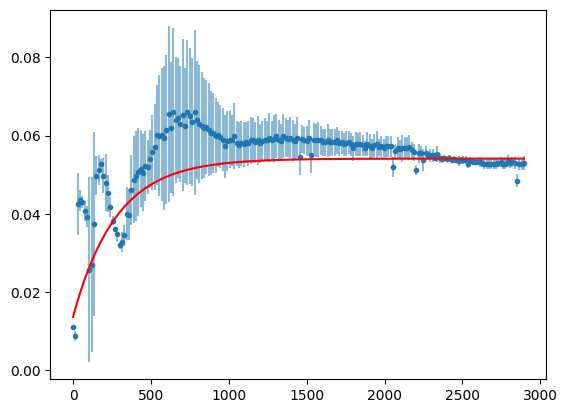

In [164]:
x = 5
#fit = 'logistic'
fit = 'gompertz4'
cut, solu = fit_growth_curve(dmean,dstd,fit,x,None)
print(dmean.columns[x])
print(np.log(2)/(solu[0][2]))
plot_growth_curves(dmean,dstd,solu,cut,x,fit)